## Problem Statement

Let $G = (N,A)$ be a complete network. Consider a fixed route $r = \{r_0,\dots,r_n\}$, where $r_0 \in N$ is the depot, and for $k \in \{1,\dots, n\}$, $r_k \in N$ is a stop at some customer. Associated with each edge $(i,j) \in A$ is a normally-distributed travel time, $t_{ij} \sim N(\mu_{ij}^t, \sigma_{ij}^t)$. Associated with each node $i \in N$ is a normally distributed service time $s_i \in N(\mu_{i}^s, \sigma_{i}^s)$. Each customer cancels with probability $p \in (0,1)$. We seek to establish an appointment time for each customer $i$. There is a linear penalty for lateness and for earliness, with per-unit time costs $c_l$ and $c_e$, respectively. Service cannot begin at a node until the appointment time, but can start late. Customer cancellations are learned of after setting the route and appointment times. In the event of customer cancellations, the truck visits the remaining customers in the order of the original sequence. Let the appointment time at node $r_i$ be given by $a_i$. Let $A_i$ be the random variable denoting the arrival time at node $r_i$, assuming the customer at $r_i$ does not cancel.. If $r_i$ does cancel, let $A_i=a_i$. The expected penalty minimization problem can then be expressed:

\begin{equation}
\min_{\{a_0,\dots, a_n\}} \sum_{i=0}^n \mathbb{E} \left[ c_e \max\{0, a_i - A_i\} + c_l \max\{0, A_i - a_i\} \right].
\end{equation}

## Decomposition Approach

Note that $A_i$ is dependent on $a_0,\dots, a_{i-1}$ (i.e., the arrival time at a node depends on the appointment times at the previous nodes). To simplify the problem, we shall instead solve a sequence of problems, iterating from $i=0$ to $i=n$:

\begin{equation}
\min_{a_i} \mathbb{E} \left[ c_e \max\{0, a_i - A_i\} + c_l \max\{0, A_i - a_i\} \right]
\end{equation}

That is, we set the appointment time for the first customer, then do the same for the second customer, then the third customer, etc. We may set $a_0=A_0=0$. For $i>0$, this is a classical newsvendor problem, which has solution:

$$a_i = F_i^{-1}\left(\frac{c_l}{c_e + c_l}\right)$$

where $F_i(x)$ is the cumulative distribution function for the random variable $A_i$ (thus, $F_i^{-1}(x)$ is the quantile function). Let $q = \frac{c_l}{c_e + c_l}$ be the critical ratio at which we evaluate the quantile function. Since we solve the problems in a sequence, we have all $a_j$ for $0 \leq j < i$, meaning we have sufficient information to calculate $F_i(x)$.


## Calculating $F_j(x)$

We seek $F_j(x) = P(A_j \le x)$ for a stop $j$. We assume we know $a_i$ for all $0 \leq i < j$. Observe:

$$P(A_j \le x) = \sum_{k=0}^{j-1} P(A_j \le x \text{ and } k \text{ cancellations}) = \sum_{k=0}^{j-1} {j-1 \choose k} p^k (1-p)^{j-1 -k} P(A_j \le x \mid k \text{ cancellations}) $$

Let $\Gamma_k$ be set of subroutes that result from deleting $k$ customers. Consider a subroute $\gamma=\{\gamma_0, \dots, \gamma_m\} \in \Gamma_k$. Note that $\gamma_0 = r_0$, $\gamma_m = r_j$, and $m = j-k$. Let $A_j^{\gamma}$ be the arrival time at node $\gamma_j$, assuming the truck travels along the subroute $\gamma$. We have:

$$P(A_j \le x \mid k \text{ cancellations}) = \frac{1}{|\Gamma_k|} \sum_{\gamma \in \Gamma_k} P(A^{\gamma}_{j-k} \le x)$$

Letting $G$ be the cumulative distribution function for a normally distributed random variable with mean $\mu$ and standard deviation $\sigma$:
$$G[\mu,\sigma](x) = \frac{1}{2} \left[1 + \text{erf} \left( \frac{x - \mu}{\sqrt{2} \sigma}\right) \right],$$
letting $Q_{i,j}^{\gamma}$ be the cumulative distribution function for the normally-distributed random variable reflecting the elapsed time between arriving at $\gamma_i$ and arriving at $\gamma_j$ along the subroute $\gamma$, assuming service commences immediately upon arrival:
$$Q_{i,j}^{\gamma}(x) = H[\{\gamma_i, \gamma_{i+1},\dots, \gamma_j\}](x)$$
where
$$H[\delta](x) = G \left[\sum_{i=1}^{|\delta|-1} \mu_{\delta_i}^s + \mu_{\delta_i,\delta_{i+1}}^t, \sum_{i=1}^{|\delta|-1} (\sigma_{\delta_i}^s)^2 + (\sigma_{\delta_i,\delta_{i+1}}^t)^2 \right](x),$$

we have the formula (proved by induction):
$$P(A^{\gamma}_1 \le x) =  Q^{\gamma}_{0,1}(x)$$
$$P(A^{\gamma}_k \le x) = \left[\prod_{i=1}^{k-1} (1-\xi_i^{\gamma})\right]Q_{0,k}^{\gamma}(x)  + \sum_{i=1}^{k-1} \left[ \prod_{j={i+1}}^{k-1}(1-\xi_j^{\gamma}) \right] \xi_i^{\gamma} Q_{i,k}^{\gamma}(x - a_{\gamma_i})$$
where 
$$\xi^{\gamma}_i = P(A^{\gamma}_i \le a_{\gamma_i})$$
Thus,

$$P(A_j \le x) = \sum_{k=0}^{j-1} {j-1 \choose k} p^k (1-p)^{j-1 -k} \frac{1}{|\Gamma_k|} \sum_{\gamma \in \Gamma_k} \left[P(A^{\gamma}_{j-k} \le x) \right]$$

## Computational Experimentation

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize # finding roots
np.random.seed(42)

Setting parameters:

In [234]:
n = 20 # number of customers (physicians see about 20 patients per day)

mean_service_time = 5 # mean service times
stddev_service_time = mean_service_time / 2 # std. dev. of service time

p = 0.05 # cancellation probability

c_e = 5 # unit earliness cost
c_l = 10 # unit lateness cost
q = c_l / (c_e + c_l) # critical ratio

SQRT_2 = math.sqrt(2)

mu_s = mean_service_time * np.ones(n+1)
sigma_s = stddev_service_time * np.ones(n+1)
mu_s[0] = 0 # no service time at the depot
sigma_s[0] = 0 

d = np.zeros([n+1, n+1])
x_coord = np.random.uniform(low=0, high=10, size=n+1)
y_coord = np.random.uniform(low=0, high=10, size=n+1)

def get_distance(i,j):
    return np.sqrt((x_coord[i] - x_coord[j]) ** 2 + (y_coord[i] - y_coord[j]) ** 2)

for i in range(n+1):
    for j in range(i,n+1):
        d[i,j] = get_distance(i,j)
        d[j,i] = d[i,j]
mu_t = np.array(d)
sigma_t = np.array(d) / 2

In [382]:
a = [] # list of appointment times
a.append(0) # appointment at depot is 0

In [236]:
def get_arrival_time(): # simulation
    cancellations = np.random.binomial(1, p, size = n+1)
    cancellations[0] = 0 # depot doesn't cancel
    cancellations[n] = 0 # last stop doesn't cancel
    arrival_time = 0
    current_stop = 0
    while current_stop < n:
        service_time = np.random.normal(mu_s, sigma_s)
        next_stop = min([j for j in range(n+1) if (j > current_stop) if cancellations[j] == 0])
        travel_time = np.random.normal(d[current_stop, next_stop], d[current_stop, next_stop] / 2)
        arrival_time += service_time + travel_time
        current_stop = next_stop
    return(arrival_time)

def get_expected_arrival_time(): # baseline model
    arrival_time = 0
    current_stop = 0
    while current_stop < n:
        service_time = mu_s
        next_stop = current_stop + 1
        travel_time = d[current_stop, next_stop]
        arrival_time += service_time + travel_time
        current_stop = next_stop
    return(arrival_time)

def get_cost(true, pred):
    # if later than prediction
    if true > pred:
        return c_l * (true - pred)
    else:
        return c_e * (pred - true)

In [237]:
def G(mu, sigma, x):
    '''Calculates the CDF of a normal distribution with mean mu and
    standard deviation sigma evaluated at a point x'''
    return (1 / 2) * (1 + math.erf((x - mu)/(SQRT_2 * sigma)))

def H(delta, x):
    '''Cumulative distribution function for the normally-distributed
    random variable reflecting the elapsed time between arriving at
    the first stop and arriving at the last stop along the subroute
    delta, assuming service commences immediately upon arrival'''
    mu = 0
    sigma = 0
    for i in range(len(delta) - 1):
        current_stop = delta[i]
        next_stop = delta[i+1]
        mu += mu_s[current_stop]
        mu += mu_t[current_stop, next_stop]
        sigma += sigma_s[current_stop] ** 2
        sigma += sigma_t[current_stop, next_stop] ** 2
    sigma = math.sqrt(sigma)
    return G(mu, sigma, x)

def Q(gamma, i, j, x):
    return H(gamma[i:(j+1)], x)

### Appointment at $r_1$

We have the following formula for the appointment at $r_1$: 
$$a_1 = F^{-1}_1(q)$$

where $F_1(x)$ is the CDF of the random variable $A_1$, representing the arrival time at $r_1$. We have 
$$F_1(x) = Q^{\gamma}_{0,1}(x)$$
where $\gamma = [r_0, r_1]$. Thus, to get $a_1$, we numerically solve 

$$Q^{\gamma}_{0,1}(x) - q = 0$$

for $x$.

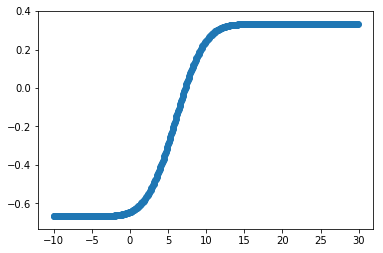

In [238]:
gamma = [0, 1]
X = np.arange(-10,30,0.1)
fig = plt.figure()
plt.scatter(X, [Q(gamma, 0, 1, x) - q for x in X])
plt.show()

In [239]:
def my_function(x):
    return Q(gamma, 0, 1, x) - q
sol = optimize.root_scalar(my_function, bracket=[0,15])
print('Appointment Time at r_1:', sol.root)
a.append(sol.root)

Appointment Time at r_1: 7.244209237906065


### Appointment at $r_2$


We have the following formula for the appointment at $r_2$: 
$$a_2 = F^{-1}_2(q)$$

where $F_2(x)$ is the CDF of the random variable $A_2$, representing the arrival time at $r_2$. We have 
\begin{align*}
F_2(x) &= \sum_{k=0}^{2-1} {2-1 \choose k} p^k (1-p)^{2-1 -k} \frac{1}{|\Gamma_k|} \sum_{\gamma \in \Gamma_k} \left[P(A^{\gamma}_{j-k} \le x) \right] \\
&= \sum_{k=0}^{1} {1 \choose k} p^k (1-p)^{1 -k} \frac{1}{|\Gamma_k|} \sum_{\gamma \in \Gamma_k} \left[P(A^{\gamma}_{2-k} \le x) \right] \\
&= (1 - p) P(A^{[0,1,2]}_{2} \le x) + p P(A^{[0,2]}_{1} \le x) \\
\end{align*}
By the general formula,
\begin{align*}
P(A^{[0,1,2]}_{2} \le x) &= \left[\prod_{i=1}^{2-1} (1-\xi_i^{\gamma})\right]Q_{0,2}^{\gamma}(x)  + \sum_{i=1}^{2-1} \left[ \prod_{j={i+1}}^{2-1}(1-\xi_j^{\gamma}) \right] \xi_i^{\gamma} Q_{i,2}^{\gamma}(x - a_{\gamma_i}) \\
&= (1-\xi_1^{[0,1,2]})Q_{0,2}^{[0,1,2]}(x)  + \xi_1^{[0,1,2]} Q_{1,2}^{[0,1,2]}(x - a_{1}) \\
\end{align*}
where $\xi_1^{[0,1,2]} = Q_{0,1}^{[0,1]}(\alpha_1)$

and

\begin{align*}
P(A^{[0,2]}_{1} \le x) = Q_{0,1}^{[0,2]}(x)
\end{align*}

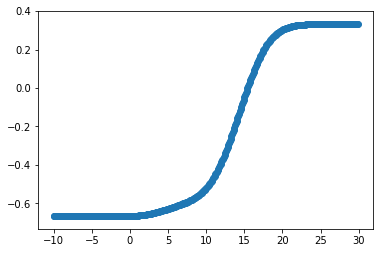

Appointment Time at r_2: 15.41622009211433


In [250]:
gamma = [0,1,2]
xi_1_gamma = Q([0,1], 0, 1, a[gamma[1]])
def F(x):
    return (1-p) * ((1 - xi_1_gamma) * Q([0,1,2], 0, 2, x) + xi_1_gamma * Q([0,1,2], 1, 2, x - a[gamma[1]])) + p * Q([0,2],0,1,x) - q
X = np.arange(-10,30,.1)
fig = plt.figure()
plt.scatter(X, [F(x) for x in X])
plt.show()
sol = optimize.root_scalar(F, bracket=[0,100])
print('Appointment Time at r_2:', sol.root)

In [251]:
def get_gamma_cdf(gamma, x):
    result = 0
    #print('Gamma', gamma)
    k = len(gamma) - 1
    # compute xi_i for i in 1 to k-1
    xi = [get_gamma_cdf(gamma[0:i+1], a[gamma[i]]) for i in range(1,k)]
    xi.insert(0,0)
    result += np.product([(1-xi[i]) for i in range(1,k)]) * Q(gamma, 0, k, x)
    #print(xi)
    for i in range(1, k):
        result += np.product([(1-xi[j]) for j in range(i+1, k)]) * xi[i] * Q(gamma, i, k, x - a[gamma[i]])
    return result

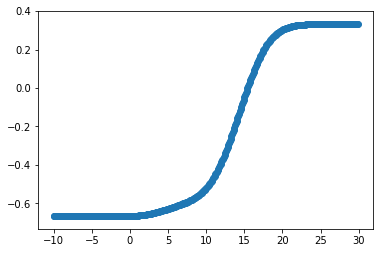

Appointment Time at r_2: 15.41622009211433


In [252]:
def F2(x):
    return (1-p) * get_gamma_cdf([0,1,2], x) + p * get_gamma_cdf([0,2], x) - q
X = np.arange(-10,30,.1)
fig = plt.figure()
plt.scatter(X, [F2(x) for x in X])
plt.show()
sol = optimize.root_scalar(F2, bracket=[0,100])
print('Appointment Time at r_2:', sol.root)
a.append(sol.root)

### Appointment at $r_3$


We have the following formula for the appointment at $r_3$: 
$$a_3 = F^{-1}_3(q)$$

where $F_3(x)$ is the CDF of the random variable $A_3$, representing the arrival time at $r_3$. We have 
\begin{align*}
F_3(x) &= \sum_{k=0}^{2} {2 \choose k} p^k (1-p)^{2 -k} \frac{1}{|\Gamma_k|} \sum_{\gamma \in \Gamma_k} \left[P(A^{\gamma}_{3-k} \le x) \right] \\
&= (1-p)^2 P(A^{[0,1,2,3]}_3 \le x) + 2p(1-p)(1/2)\left[P(A^{[0,1,3]}_2 \le x) + P(A^{[0,2,3]}_2 \le x)\right] + p^2 P(A^{[0,3]}_2 \le x)
\end{align*}

We have:
\begin{align*}
P(A^{[0,1,2,3]}_3 \le x) = \xi_2^{[0,1,2,3]} Q_{2,3}^{[0,1,2,3]}(x-a_2) + (1-\xi_2^{[0,1,2,3]}) \xi_1^{[0,1,2,3]} Q_{1,3}^{[0,1,2,3]}(x-a_1) + (1-\xi_2^{[0,1,2,3]})(1 - \xi_1^{[0,1,2,3]}) Q_{0,3}^{[0,1,2,3]}(x)
\end{align*}
where $\xi_1^{[0,1,2,3]} =  Q_{0,1}^{[0,1,2,3]}(a_1)$ and $\xi_2^{[0,1,2,3]} = P(A_2 \le a_2 \mid \text{Traveling along path $[0,1,2,3]$}) \neq Q_{0,2}^{[0,1,2,3]}(a_2)$

\begin{align*}
P(A^{[0,2,3]}_3 \le x) &= (1-\xi_1^{[0,2,3]})Q_{0,2}^{[0,2,3]}(x)  + \xi_1^{[0,2,3]} Q_{1,2}^{[0,2,3]}(x - a_{2}) \\
&= (1-Q_{0,1}^{[0,2,3]}(a_2))Q_{0,2}^{[0,2,3]}(x)  + Q_{0,1}^{[0,2,3]}(a_2) Q_{1,2}^{[0,2,3]}(x - a_{2})
\end{align*}


\begin{align*}
P(A^{[0,1,3]}_3 \le x) &= (1-\xi_1^{[0,1,3]})Q_{0,2}^{[0,1,3]}(x)  + \xi_1^{[0,1,3]} Q_{1,2}^{[0,1,3]}(x - a_{1}) \\
&= (1-Q_{0,1}^{[0,1,3]}(a_1))Q_{0,2}^{[0,1,3]}(x)  + Q_{0,1}^{[0,1,3]}(a_1) Q_{1,2}^{[0,1,3]}(x - a_{1})
\end{align*}


\begin{align*}
P(A^{[0,3]}_3 \le x) = Q_{0,1}^{[0,3]}(x)
\end{align*}

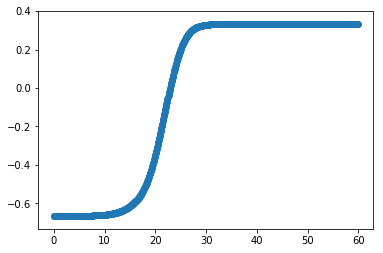

Appointment Time at r_3: 22.882861143746783


In [243]:
### Doing it 'manually'
def manual_F3(x):
    result = 0
    gamma = [0,1,2,3]
    ### first term:
    result += ((1-p) ** 2) * (0.6491228070291168 * Q(gamma, 2, 3, x - a[2]) + (1 - 0.6491228070291168) * Q(gamma,0,1,a[1]) * Q(gamma, 1,3,x-a[1]) + (1 - 0.6491228070291168) * (1 - Q(gamma, 0,1, a[1])) * Q(gamma, 0, 3, x))
    
    ### second term:
    gamma = [0,1,3]
    result += p * (1 - p) * ((1-Q(gamma, 0,1,a[1]))*(Q(gamma, 0, 2, x)) + (Q(gamma,0,1,a[1]))*(Q(gamma,1,2,x-a[1])))
    
    ### third term:
    gamma = [0,2,3]
    result += p * (1 - p) * ((1-Q(gamma, 0,1,a[2]))*(Q(gamma, 0, 2, x)) + (Q(gamma,0,1,a[2]))*(Q(gamma,1,2,x-a[2])))
    
    ### fourth term:
    gamma = [0,3]
    result += (p ** 2) * Q(gamma, 0,1,x)
    
    return result - q

X = np.arange(-0,60,.1)
fig = plt.figure()
plt.scatter(X, [manual_F3(x) for x in X])
plt.show()
sol = optimize.root_scalar(manual_F3, bracket=[0,50])
print('Appointment Time at r_3:', sol.root)

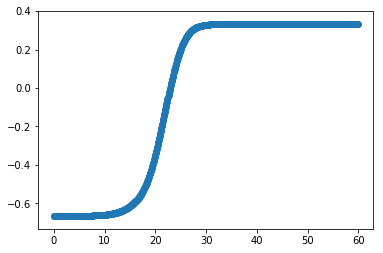

Appointment Time at r_3: 22.88286114541126


In [253]:
## Using the get_gamma_cdf code
def F3(x):
    return ((1-p) ** 2) * get_gamma_cdf([0,1,2,3], x) + p * (1 - p) * (get_gamma_cdf([0, 2, 3], x) + get_gamma_cdf([0,1,3], x)) + (p ** 2) * get_gamma_cdf([0,3], x) - q
X = np.arange(-0,60,.1)
fig = plt.figure()
plt.scatter(X, [F3(x) for x in X])
plt.show()
sol = optimize.root_scalar(F3, bracket=[0,50])
print('Appointment Time at r_3:', sol.root)
#a.append(sol.root)

In [245]:
from scipy import special
special.comb(10, 3)

120.0

$$P(A_j \le x) = \sum_{k=0}^{j-1} {j-1 \choose k} p^k (1-p)^{j-1 -k} \frac{1}{|\Gamma_k|} \sum_{\gamma \in \Gamma_k} \left[P(A^{\gamma}_{j-k} \le x) \right]$$

In [259]:
import itertools
def get_subroutes(route, k):
    """Given a route and a number k, returns the set of routes that emerge from deleting k customers"""
    assert k <= len(route)-2, 'k is too large'
    original = route.copy()
    intermediates = original[1:-1]
    m = len(intermediates) 
    subroutes = [[original[0]] + list(subroute) + [original[-1]] for subroute in itertools.combinations(intermediates, m - k)]
    return subroutes

def get_CDF(j, x):
    route = [i for i in range(0,j+1)]
    result = 0
    for k in range(j):
        subroutes = get_subroutes(route, k)
        term = 0
        for gamma in subroutes:
            term += get_gamma_cdf(gamma, x)
        term = special.comb(j - 1, k) * term
        term = ( p ** k) * ((1 - p) ** (j - 1 - k)) * term
        term = (1 / len(subroutes)) * term
        result += term
    return result 
    

In [388]:
def plot_CDF(j):
    def my_F(x):
        return get_CDF(j,x) - q
    sol = optimize.root_scalar(my_F, bracket=[0,70])
    Z = np.arange(0,60,1)
    plt.plot(Z, [get_CDF(j, z) for z in Z])
    plt.plot()
    plt.scatter(sol.root, q, c='red')
    plt.vlines(x=sol.root, ymin=0, ymax=q,colors = 'black', linestyles='dashed', label=f'a_{j}')
    
    #plt.annotate(f'$a_{j}$',(sol.root, 0),(sol.root,-.1))
    print(f"Appointment for Stop {j}: {np.round(sol.root,2)}")
    if len(a) < j+1:
        a.append(sol.root)
    plt.xticks(a, [f'$a_{i}$={np.round(a[i],2)}' for i in range(len(a))],rotation=45)


Cancellation probability: 0.6
Appointment for Stop 1: 7.24
Appointment for Stop 2: 11.08
Appointment for Stop 3: 19.52
Appointment for Stop 4: 30.49
Appointment for Stop 5: 40.08


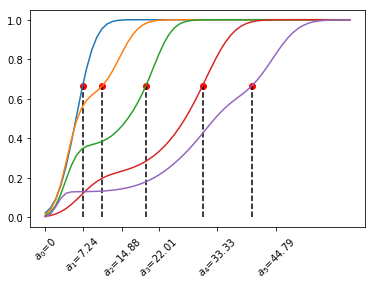

In [392]:
p = 0.6
print(f"Cancellation probability: {np.round(p,2)}")
plt.figure()
for j in range(1,6):
    plot_CDF(j)
#plt.legend()
plt.show()